In [2]:
import numpy as np
from pathlib import Path
import table
import tensorflow as tf
import pandas as pd
import re
from tqdm import tqdm
from collections import defaultdict
import keras
from linked_neurons import SeparatingReLU
from keras.models import model_from_json
import dill as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from slugify import slugify


# %load_ext line_profiler

Using TensorFlow backend.


In [4]:
def extract_metrics(event_file):
    results = []
    for e in tf.train.summary_iterator(event_file):
        for v in e.summary.value:
            if v.tag.endswith('loss') or v.tag.endswith('acc'):
                results.append((e.step, e.wall_time, v.tag, v.simple_value))

    return pd.DataFrame(results, columns=['epoch', 'wall time', 'tag', 'value'])


path = Path('./moons_grid_summaries/')

selected_activations = None
architecture_regex = re.compile('-(\d+)x(\d+)-')
sr_regex = re.compile('-sr-(\d+)(?:-(\d+))?-')
if not results:
    results = defaultdict(lambda: defaultdict(pd.DataFrame)) # tag, activation
for summary_path in tqdm(path.iterdir(), total=len(list(path.iterdir()))):
    if summary_path.is_dir():
        path = summary_path
        event_file = list(path.glob('*events*'))            
        if event_file:                    
            event_file = str(event_file[0].resolve())
            depth, width = architecture_regex.search(event_file).groups()
            depth, width = int(depth), int(width)
            if 'separating' in event_file:
                match = sr_regex.search(event_file)
                if match is None:
                    continue
                else:
                    integer, decimal = match.groups()
                    lmda = integer+'.'+decimal if decimal else integer
                    lmda = float(lmda)
                    if 'a-none' in event_file:
                        activation = f'Sep-L {lmda}'
                    elif 'a-0-1' in event_file:
                        activation = f'Sep-UP {lmda}'
                    elif 'a-0' in event_file:
                        activation = f'Sep-U {lmda}'
                    elif 'a-1' in event_file:
                        activation = f'Sep-P {lmda}'

                    else:
                        raise RuntimeError(f'Unknown activation {activation}')

                    if 'zero' in event_file:
                        activation +=' zero'
                    if 'nm-0' in event_file:
                        activation += ' nm-0'

            else:
                if 'relu-bn' in event_file:
                    activation = 'relu-bn'
                else:
                    activation = 'relu'

            if not selected_activations or activation in selected_activations:

                try:
                    acc = results['acc'][activation].loc[width, depth]
                    val_acc = results['val_acc'][activation].loc[width, depth]
                    if np.isnan(acc) or np.isnan(val_acc):
                        metrics = extract_metrics(event_file)
                        best = metrics.groupby('tag').max()['value']

                        results['acc'][activation].loc[width, depth] = best['acc']
                        results['val_acc'][activation].loc[width, depth] = best['val_acc']
                        print(summary_path)

                except KeyError:
                    metrics = extract_metrics(event_file)
                    best = metrics.groupby('tag').max()['value']

                    results['acc'][activation].loc[width, depth] = best['acc']
                    results['val_acc'][activation].loc[width, depth] = best['val_acc']
                    print(summary_path)




            


  6%|▌         | 142/2389 [00:00<00:01, 1415.48it/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


 12%|█▏        | 288/2389 [00:00<00:01, 1426.49it/s]

moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-120x20-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-5-0-crossentropy-adam-0-01-bs-85-2019-06-22-04-05-18


 21%|██        | 490/2389 [00:00<00:02, 857.06it/s] 

moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-120x10-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-3-0-crossentropy-adam-0-01-bs-85-2019-06-21-23-52-34


 28%|██▊       | 658/2389 [00:01<00:02, 673.74it/s]

moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-80x15-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-0-crossentropy-adam-0-01-bs-85-2019-06-21-20-28-12


 30%|███       | 717/2389 [00:01<00:04, 390.22it/s]

moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-120x4-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-1-0-crossentropy-adam-0-01-bs-85-2019-06-21-21-15-56


 34%|███▍      | 817/2389 [00:01<00:04, 364.83it/s]

moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-120x15-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-4-0-crossentropy-adam-0-01-bs-85-2019-06-22-01-47-21


 37%|███▋      | 877/2389 [00:01<00:05, 293.99it/s]

moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-120x5-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-2-0-crossentropy-adam-0-01-bs-85-2019-06-21-22-22-57
moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-150x25-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-0-crossentropy-adam-0-01-bs-85-2019-06-26-09-53-29


 56%|█████▋    | 1346/2389 [00:02<00:02, 468.51it/s]

moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-120x3-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-0-crossentropy-adam-0-01-bs-85-2019-06-21-20-30-00


 92%|█████████▏| 2186/2389 [00:02<00:00, 830.35it/s]

moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-80x25-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-2-0-crossentropy-adam-0-01-bs-85-2019-06-21-21-31-13
moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-120x25-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-6-0-crossentropy-adam-0-01-bs-85-2019-06-22-06-02-38


100%|██████████| 2389/2389 [00:03<00:00, 767.80it/s]

moons_grid_summaries/moons-grid-zero-separating-relu-annealing-dropout-80x20-ks-none-lp-p-same-ki-zeros-bi-zeros-b-0-51-sr-0-0001-ub-true-a-0-1-r-dropout-rate-1-0-crossentropy-adam-0-01-bs-85-2019-06-21-20-55-35


In [139]:
import dill as pkl
with open('moons-results-grid.pkl', 'wb') as f:
    pkl.dump(results , f)
    

In [3]:
import dill as pkl
with open('moons-results-grid.pkl', 'rb') as f:
    results = pkl.load(f)

In [67]:
good = ['relu', 'relu-bn', 'Sep-U 0.0001', 'Sep-P 0.0001', 'Sep-UP 0.0001', 'Sep-UP 0.0001 zero' ]

for metric_name, metric in results.items():
    print(metric_name)
    if metric_name == 'val_acc':
        for activation_name in good:
            activation = metric[activation_name]
            activation = activation.sort_index().sort_index(axis=1)
            print(activation_name)
            print(activation[2:4].T)
            print()

acc
val_acc
relu
            3         4
1    0.666667  0.733333
2    1.000000  1.000000
3    0.733333  1.000000
4    1.000000  1.000000
5    0.400000  1.000000
10   1.000000  1.000000
15   0.733333  0.400000
20   0.400000  0.400000
25   0.400000  0.866667
30   0.400000  0.400000
35   0.400000  0.400000
40   0.400000  0.400000
45   0.400000  0.400000
50   0.400000  0.400000
60   0.400000  0.400000
70   0.400000  0.400000
80   0.400000  0.400000
90   0.400000  0.400000
100  0.400000  0.400000
110  0.400000  0.400000
120  0.400000  0.400000
130  0.400000  0.400000
140  0.400000  0.400000
150  0.400000  0.400000

relu-bn
            3         4
1    0.733333  1.000000
2    1.000000  1.000000
3    1.000000  1.000000
4    1.000000  1.000000
5    0.933333  1.000000
10   1.000000  0.866667
15   0.866667  0.800000
20   0.866667  0.800000
25   0.933333  0.800000
30   0.800000  0.600000
35   0.666667  0.800000
40   0.733333  0.800000
45   0.600000  0.666667
50   0.866667  0.733333
60   0.733333 

acc
val_acc


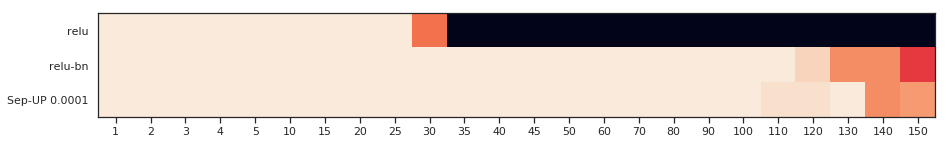

In [253]:
from collections import defaultdict

data = {}
for metric_name, metric in results.items():
    print(metric_name)
    metric_data = {}
    for activation_name, activation in metric.items():
        if True:#'zero' in activation_name:    
            activation_data = activation.sort_index().sort_index(axis=1)
            metric_data[activation_name] = activation_data[:25].max(axis=0)
        data[metric_name] = pd.DataFrame(metric_data)
        
            
best = pd.concat(data).T
b = best['acc'].sort_values(150, ascending=False)
b = b.loc[['relu', 'relu-bn', 'Sep-UP 0.0001']]
fig, ax = plt.subplots(1, figsize=(15,25))
ax.matshow(b, vmin=0.60, vmax=1,)
ax.set_xticks(range(len(b.columns)))
ax.set_yticks(range(len(b.index)))
ax.set_xticklabels(b.columns)
ax.set_yticklabels(b.index)
ax.xaxis.set_ticks_position('bottom')
# b.T.plot(figsize=(25,15))

dict_keys(['Sep-UP 0.0001 nm-0', 'Sep-UP 0.0001', 'Sep-U 0.0001', 'Sep-UP 0.01', 'relu-bn', 'Sep-P 0.0001', 'Sep-UP 0.0001 zero', 'Sep-L 0.0001', 'relu', 'Sep-UP 0.0001 zero nm-0'])
dict_keys(['Sep-UP 0.0001 nm-0', 'Sep-UP 0.0001', 'Sep-U 0.0001', 'Sep-UP 0.01', 'relu-bn', 'Sep-P 0.0001', 'Sep-UP 0.0001 zero', 'Sep-L 0.0001', 'relu', 'Sep-UP 0.0001 zero nm-0'])


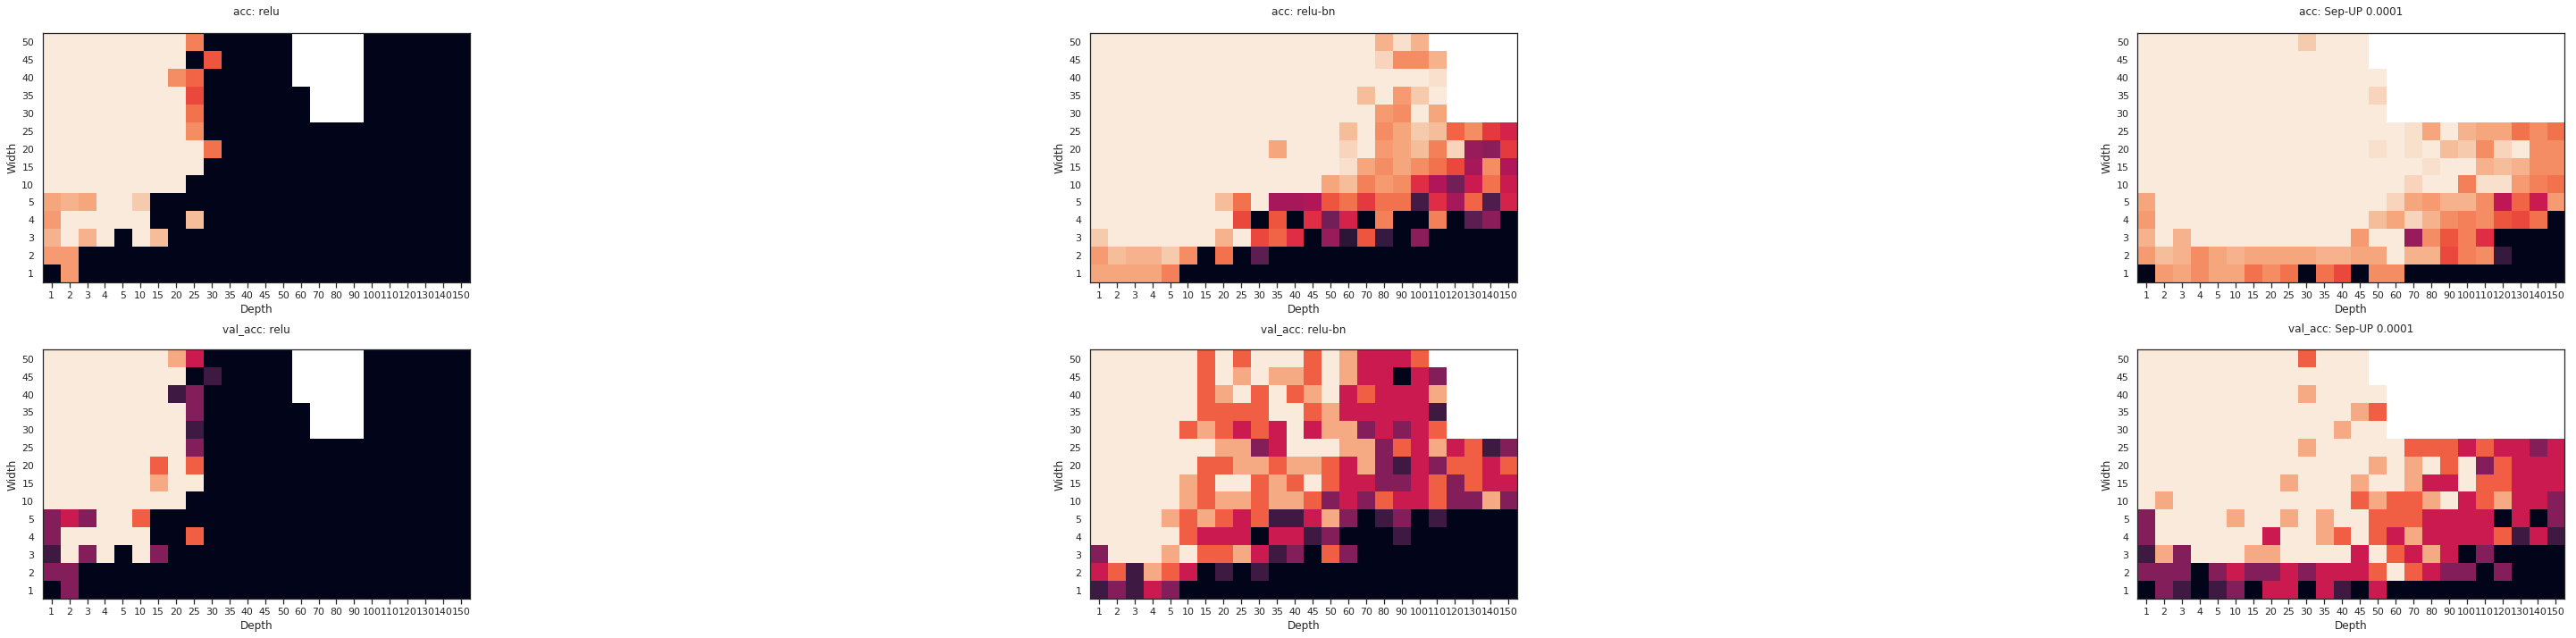

In [250]:
sns.set_style("white")
activations = ['relu', 'relu-bn', 'Sep-UP 0.0001']#,  'Sep-UP 0.0001 zero', 'Sep-UP 0.0001 zero nm-0', 'Sep-UP 0.0001 nm-0', 'Sep-UP 0.01', 'Sep-U 0.0001',  'Sep-P 0.0001',  'Sep-L 0.0001',  ]
fig, axes = plt.subplots(2,len(activations), figsize=(55, 10))
axes[0,0].set_title('acc')
axes[1,0].set_title('val acc')

axes = iter(axes.flatten())

for metric_name, metric in results.items():
    print(metric.keys())
#     activations = sorted(list(metric.keys()), reverse=True)
    
    for activation_name in activations:
        activation = metric[activation_name]
        activation = activation.sort_index().sort_index(axis=1)
#         activation = activation.loc[:25]
#         activation = activation.loc[:,:50]

        ax = next(axes)
        ax.matshow(activation, vmin=0.60, vmax=1, origin='lower')
        ax.set_title(f'{metric_name}: {activation_name}')
        ax.set_xticks(range(len(activation.columns)))
        ax.set_yticks(range(len(activation.index)))
        ax.set_xticklabels(activation.columns)
        ax.set_yticklabels(activation.index[:25])
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Depth')
        ax.set_ylabel('Width')

fig.tight_layout()

dict_keys(['Sep-UP 0.0001 nm-0', 'Sep-UP 0.0001', 'Sep-U 0.0001', 'Sep-UP 0.01', 'relu-bn', 'Sep-P 0.0001', 'Sep-UP 0.0001 zero', 'Sep-L 0.0001', 'relu', 'Sep-UP 0.0001 zero nm-0'])
dict_keys(['Sep-UP 0.0001 nm-0', 'Sep-UP 0.0001', 'Sep-U 0.0001', 'Sep-UP 0.01', 'relu-bn', 'Sep-P 0.0001', 'Sep-UP 0.0001 zero', 'Sep-L 0.0001', 'relu', 'Sep-UP 0.0001 zero nm-0'])


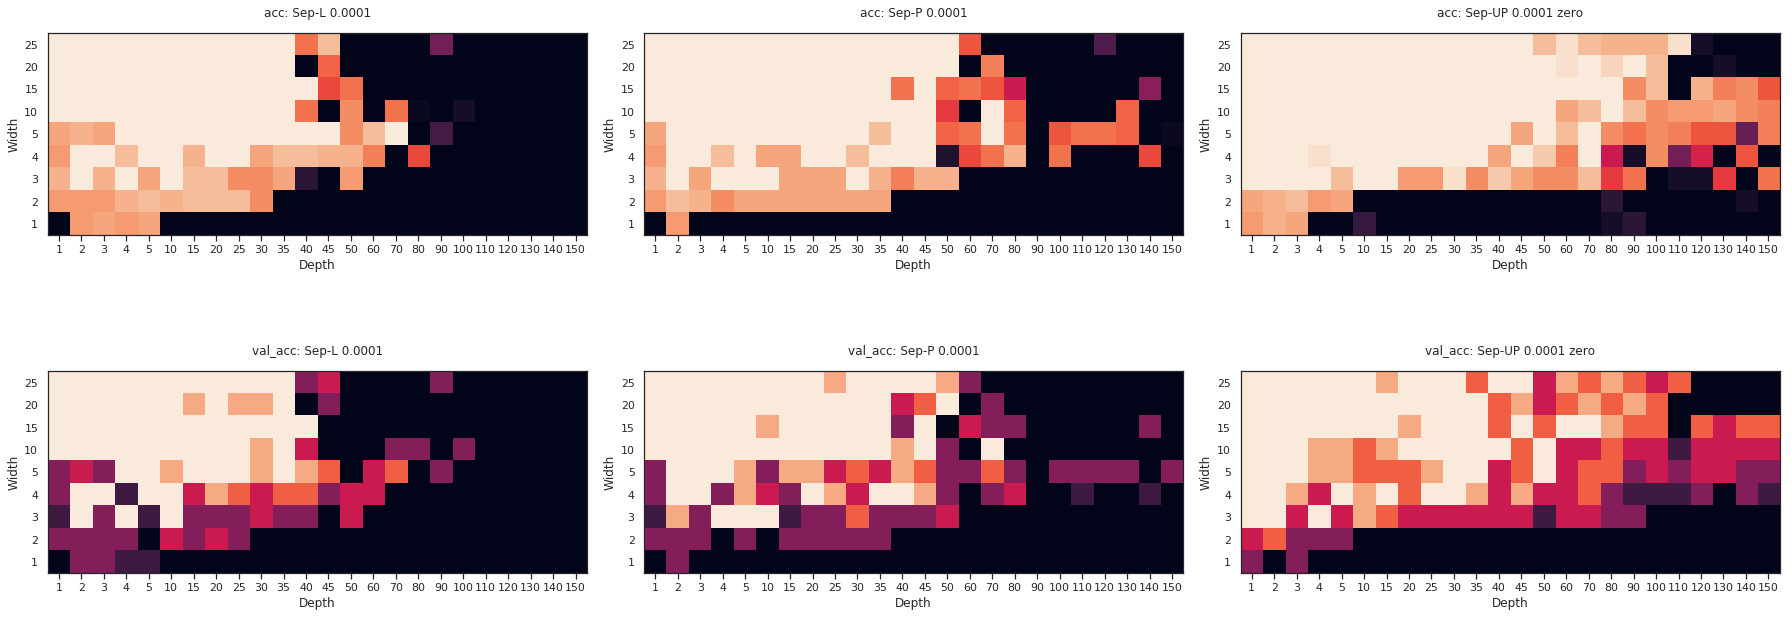

In [5]:
sns.set_style("white")
# activations = ['Sep-UP 0.0001', 'Sep-UP 0.0001 nm-0', ]
activations = ['Sep-L 0.0001', 'Sep-P 0.0001','Sep-UP 0.0001 zero',  ]
fig, axes = plt.subplots(2,len(activations), figsize=(25, 10))
axes[0,0].set_title('acc')
axes[1,0].set_title('val acc')

axes = iter(axes.flatten())

for metric_name, metric in results.items():
    print(metric.keys())
#     activations = sorted(list(metric.keys()), reverse=True)
    
    for activation_name in activations:
        activation = metric[activation_name]
        activation = activation.sort_index().sort_index(axis=1)
        activation = activation.loc[:25, :150]
        ax = next(axes)
        ax.matshow(activation, origin='lower', vmin=0.60, vmax=1,)
        ax.set_title(f'{metric_name}: {activation_name}')
        ax.set_xticks(range(len(activation.columns)))
        ax.set_yticks(range(len(activation.index)))
        ax.set_xticklabels(activation.columns)
        ax.set_yticklabels(activation.index[:25])
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Depth')
        ax.set_ylabel('Width')

fig.tight_layout()

dict_keys(['Sep-UP 0.0001 nm-0', 'Sep-UP 0.0001', 'Sep-U 0.0001', 'Sep-UP 0.01', 'relu-bn', 'Sep-P 0.0001', 'Sep-UP 0.0001 zero', 'Sep-L 0.0001', 'relu', 'Sep-UP 0.0001 zero nm-0'])
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
dict_keys(['Sep-UP 0.0001 nm-0', 'Sep-UP 0.0001', 'Sep-U 0.0001', 'Sep-UP 0.01', 'relu-bn', 'Sep-P 0.0001', 'Sep-UP 0.0001 zero', 'Sep-L 0.0001', 'relu', 'Sep-UP 0.0001 zero nm-0'])
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9 12] [  1  30  60  90 120]
[ 0  3  6  9

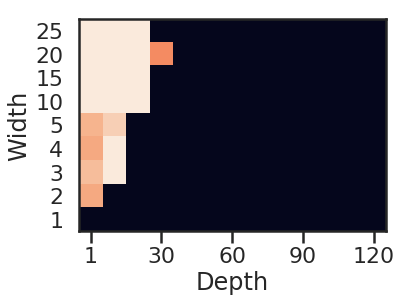

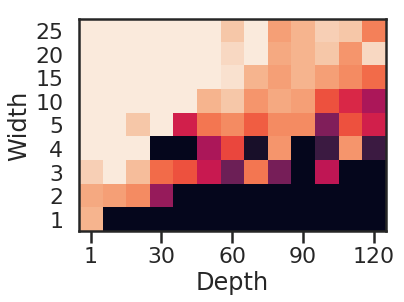

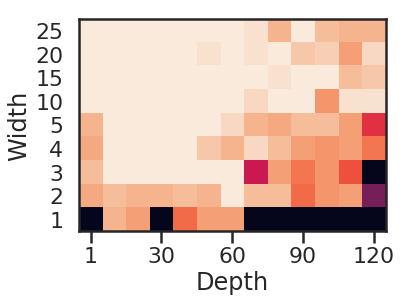

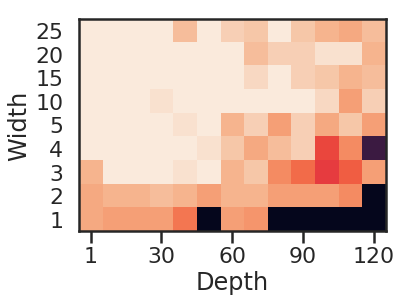

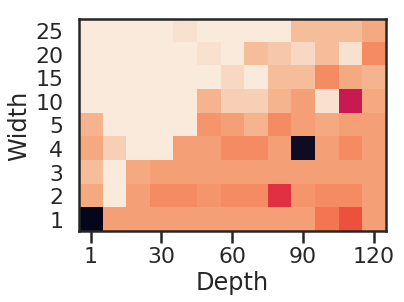

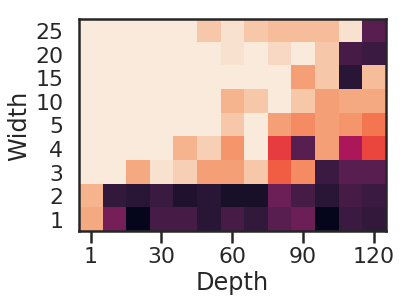

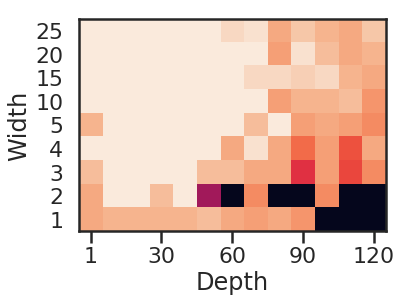

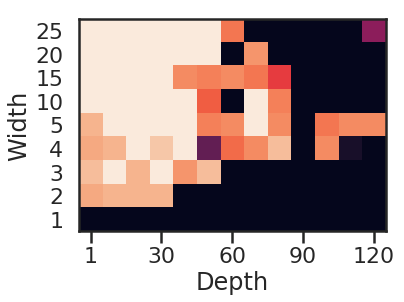

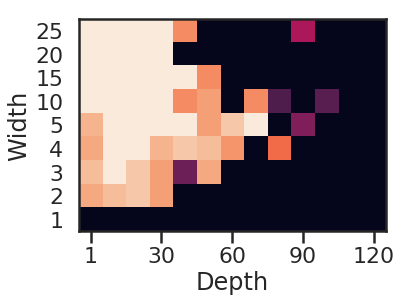

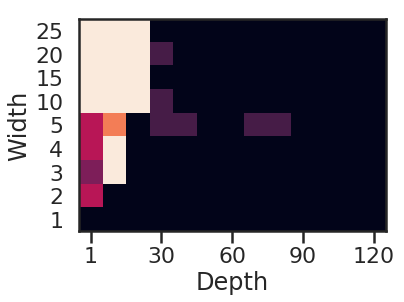

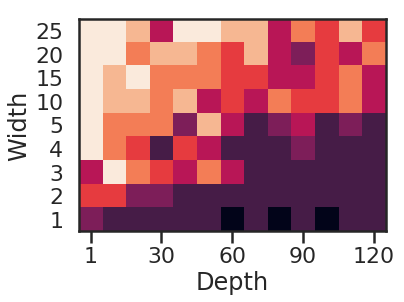

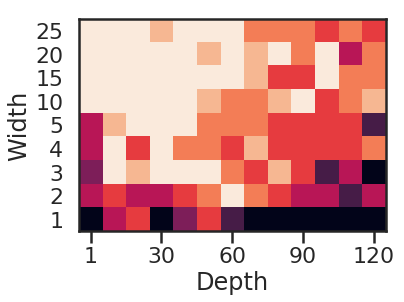

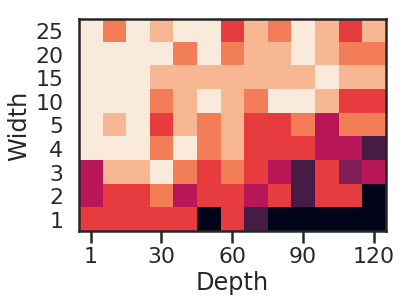

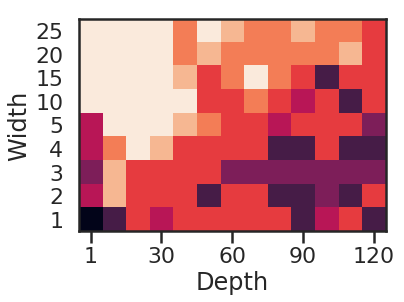

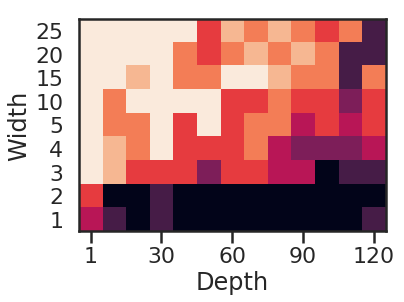

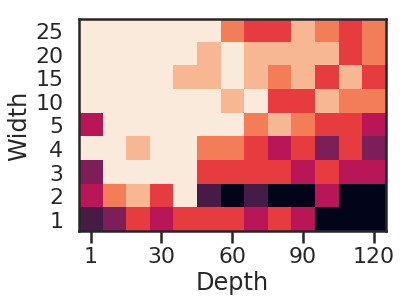

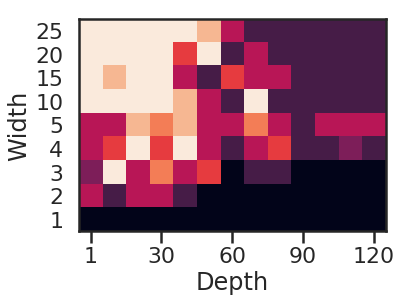

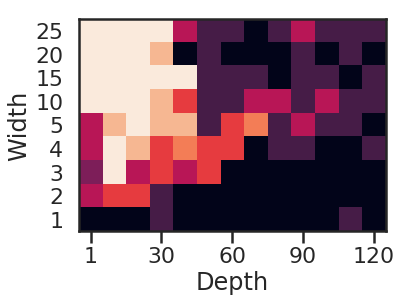

In [55]:
sns.set_style("white")
# sns.set_context('talk', font_scale=0.9)
sns.set_context('poster')
activations = ['relu', 'relu-bn', 'Sep-UP 0.0001', 'Sep-UP 0.01', 'Sep-U 0.0001',  'Sep-UP 0.0001 zero', 'Sep-UP 0.0001 nm-0', 'Sep-P 0.0001',  'Sep-L 0.0001',  ]
output_dir = Path('plots/moons_grid')
output_dir.mkdir(parents=True, exist_ok=True)
good = np.array([1] + list(range(10, 121, 10)))

for metric_name, metric in results.items():
    print(metric.keys())
#     activations = sorted(list(metric.keys()), reverse=True)
    
    for activation_name in activations:
        activation = metric[activation_name]
        activation = activation.sort_index().sort_index(axis=1)
        activation = activation.loc[:25, good]
        fig, ax = plt.subplots(1)
        ax.matshow(activation,origin='lower', vmin=0.51, vmax=1)

            
        ax.set_yticks(range(len(activation.index)))
        ax.set_yticklabels(activation.index[:25])
        
        ticks = np.arange(0, len(activation.columns), 3)
        print(ticks, good[ticks])    
        ax.set_xticks(ticks)
        ax.set_xticklabels(good[ticks])
        
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Depth')
        ax.set_ylabel('Width')
        fig.tight_layout(pad=0)
        fig.savefig(output_dir.joinpath( slugify(f'{metric_name}-{activation_name}') + '.pdf'))
        
